<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Figure-2" data-toc-modified-id="Figure-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 2</a></span></li><li><span><a href="#Figures--S2-and-S3" data-toc-modified-id="Figures--S2-and-S3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figures  S2 and S3</a></span></li></ul></div>

This notebook allows to reproduce the results of Fig. 2 of the main text of the manuscript and Figures S2 and S3 of the supplementary materials.

It plots the data resulting from running the scripts in folders 2a and 2c :
In folder 2a_* :
$ python3 script.py params.ini

In folder 2c_* :
$ python3 ../optimization.py params.ini

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys, os
import numpy as np
from lmfit import minimize, Parameters
import rgf_grape

fold_optim = '2c_optimize_magnetic_texture/'
fold_optim_results = fold_optim + 'results/'
fold_sweep = '2a_sweep_magnetic_field/'
name_fig2 = 'fig2_reality_checks.pdf'
name_figS2 = 'fig_SM_boundary.pdf'
name_figS3 = 'fig_SM_boundary_fit.pdf'

Program started on 2018-11-15 14:08:09.354723
Current git version 119c190
Randomly chosen seed =  64931329


/home/sboutin/environments/rgf_grape/lib/python3.6/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
# Plotting utilities 
import matplotlib as mpl
from matplotlib import pyplot as plt
color_cycle=plt.rcParams['axes.prop_cycle'].by_key()['color']

def useTexFonts(fontSize):
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = 'cmr10'
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['text.latex.unicode'] = True
    font = {'size'   : fontSize}
    mpl.rc('font', **font)

def setFrameThickness(fig,t):
    for i, ax in enumerate(fig.axes) :
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(t)

def setAspectRatio(fig, aspectratio):
    for i, ax in enumerate(fig.axes) :
        xRange = ax.get_xlim()[1]-ax.get_xlim()[0]
        yRange = ax.get_ylim()[1]-ax.get_ylim()[0]
        ratio_default= xRange/yRange
        ax.set_aspect(ratio_default*aspectratio)

def generate_axis_grid(figsize=(12/2.54, 14/2.54)):
    fig = plt.figure(figsize=figsize, dpi=72)
    ax1 = plt.subplot2grid((3, 10), (0, 0), colspan=7)
    ax1r = plt.subplot2grid((3, 10), (0, 7), colspan=1)
    ax2 = plt.subplot2grid((3, 10), (1, 0), colspan=7)
    ax2r = plt.subplot2grid((3, 10), (1, 7), colspan=2)
    ax3 = plt.subplot2grid((3, 10), (2, 0), colspan=7)
    ax3r = plt.subplot2grid((3, 10), (2, 7), colspan=2)
    plt.tight_layout()
    ax = [ax1,ax2,ax3]
    axr = [ax1r, ax2r, ax3r]
    return fig, ax, axr
        
useTexFonts(6)

In [3]:
# Calculate xl and xr from ldos
def calc_xl(ldos):
    N = ldos.size
    xl = np.sum([(x+2)*ld for x,ld in enumerate(ldos[1:N//2])])
    norm_l = np.sum([ld for x,ld in enumerate(ldos[1:N//2])])
    return xl/norm_l
def calc_xr(ldos):
    N = ldos.size
    xr = np.sum([(x+N//2+1)*ld for x,ld in enumerate(ldos[N//2:-1])])
    norm_r = np.sum([ld for x,ld in enumerate(ldos[N//2+1:-1])])
    return xr/norm_r



# Figure 2

<IPython.core.display.Javascript object>


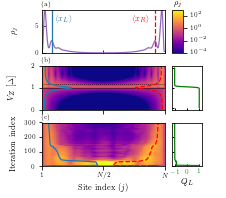

/home/sboutin/environments/rgf_grape/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


1.1555555555555557
1.0


/home/sboutin/environments/rgf_grape/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


In [4]:
def generate_data_sweep(fold_sweep, db_vals):
    data_ldos = []
    data = []
    for i, db in enumerate(db_vals):
        pth = fold_sweep+'texture energies_{}/opt_0_ldos.pkl'.format(i)
        data_ldos.append(rgf_grape.utilities.load_file(pth)[1])
        pth = fold_sweep+'texture energies_{}/opt_0_iter.pkl'.format(i)
        data.append(rgf_grape.utilities.load_file(pth)[1])
    data_ldos = np.array(data_ldos)
    data = np.array(data)
    data_ldos_scaled = np.array(data_ldos)
    xl = []
    xr = []
    for i in range(data_ldos.shape[0]):
        xl.append(calc_xl(data_ldos[i,:]))
        xr.append(calc_xr(data_ldos[i,:]))
    xl = np.array(xl)
    xr = np.array(xr)
    site = range(1, data_ldos.shape[1]+1)
    return data_ldos_scaled, data, xl, xr, site
    
def generate_data_optim(fold_optim,n=None):
    data_ldos = np.array(rgf_grape.utilities.load_file(fold_optim+'opt_0_ldos.pkl')[1:-1])
    data = np.array(rgf_grape.utilities.load_file(fold_optim+'opt_0_iter.pkl')[1:-1])
    xl = []
    xr = []
    if n is None :
        n = data_ldos.shape[0]
    else:
        n = min(n,data_ldos.shape[0])
    data_ldos_scaled = np.array(data_ldos[:n,:])
    
    for i in range(n):
#         data_ldos_scaled[i,:] = data_ldos[i,:]/data_ldos[i,:].max()
        xl.append(calc_xl(data_ldos[i,:]))
        xr.append(calc_xr(data_ldos[i,:]))
    xl = np.array(xl)
    xr = np.array(xr)
    
    iters = range(data_ldos_scaled.shape[0])
    return data_ldos_scaled, data[:n, :], xl, xr, iters

def figure2_checks(fold_sweep, fold_optim, fname, plot_phi=False, plot_map=True, N1=400, N2=200):
    N=N1
    lw=1.25
    labelx=-0.2
    delta = 0.0225
    db_vals = np.linspace(0,0.045,91)/delta
    ldos0, data0, xl0, xr0, site = generate_data_sweep(fold_sweep, db_vals)
    
    ldos1, data1, xl1, xr1, iters = generate_data_optim(fold_optim, n=300)
    nb_iter = ldos1.shape[0]
    
    vmin=-4
    vmax=3
    fig, axarr, axr = generate_axis_grid(figsize=(8/2.54, 7/2.54))

    ### PLOT 1
    ax = axarr[0]
    index=-39
    ldos=ldos0[index,:]
    ax.plot(range(2,N//2+1), ldos[1:N//2], color='#9467bd',lw=lw)
    ax.plot(range(N//2+1,N),ldos[N//2:-1], color='#9467bd',lw=lw)

    ym=1
    ax.axvline(xl0[index],ymax=ym, color='#1f77b4', lw=lw)
    ax.axvline(xr0[index],ymax=ym, color='r', ls='--', lw=lw)
    
    ax.set_ylim(0,8)
    ax.set_xlim(1,400)
    ax.set_xticks([1,N//2, N])
    ax.axes.xaxis.set_ticklabels([])
#     ax.set_ylabel('LDOS(E=0)')
    ax.set_ylabel(r'$\rho_j$', fontsize=8)
    ax.text(xl0[index]+10,0.7*8, r'$\langle x_L\rangle$', color='#1f77b4', fontsize=8)
    ax.text(xr0[index]-75,0.7*8, r'$\langle x_R\rangle$', color='r', fontsize=8)
    ax.yaxis.set_label_coords(labelx, 0.5)
    
    ### PLOT 2
    ax = axarr[1]
    if plot_map:
        im0 = ax.imshow(ldos0,origin='lower', 
                  extent=[site[0],site[-1],db_vals[0],db_vals[-1]], 
                  norm=mpl.colors.LogNorm(vmin=10**vmin,vmax=10**vmax),
                  cmap='plasma')
    ax.axhline(db_vals[45], color='k', ls='-', lw=0.5)
    ax.axhline(db_vals[index], color='k', ls=':', lw=0.75)
    ax.plot(xl0, db_vals, lw=lw)
    ax.plot(xr0, db_vals, lw=lw, color='r', ls='--')
    print(db_vals[index])
    print(db_vals[45])
    ax.set_xlim(1,400)
    ax.set_xticks([1,N//2, N])
    ax.axes.xaxis.set_ticklabels([])
    ax.set_aspect('auto')
    ax.set_ylabel(r'$V_Z$ [$\Delta$]', fontsize=8)
    ax.set_ylim(db_vals[0], db_vals[-1])
    ax.yaxis.set_label_coords(labelx, 0.5)
    
    ax2 = axr[1]
    if plot_phi:
        ax2.plot(data0[:,1], db_vals, color='g', lw=lw)
    else:
        ax2.plot(data0[:,4], db_vals, color='g', lw=lw)
        ax2.set_xlim(-1.2,1.2)
        ax2.set_xticks([-1,0,1]) 
        ax2.set_xticklabels(['','',''])
        plt.xticks([-1,0,1], color='g')
        
    ax2.set_yticks([0,1,2])
    ax2.set_yticklabels([])
    
    ### Plot3:
    ax= axarr[2]
    if plot_map:
        im1 = ax.imshow(ldos1,origin='lower', 
                  extent=[site[0],site[-1],0,nb_iter-1], 
                  aspect=site[-1]/nb_iter*1,
                  norm=mpl.colors.LogNorm(vmin=10**vmin,vmax=10**vmax),
                  cmap='plasma')
    line = ax.plot(xl1*N1/N2, iters, lw=lw)[0]
    line = ax.plot(xr1*N1/N2, iters, lw=lw, color='r', ls='--')[0]
    
    ax.set_aspect('auto')
    ax.set_ylabel(r'Iteration index', fontsize=8)
    ax.set_xlabel('Site index ($j$)', fontsize=8)
    ax.set_xticks([1,N//2, N])
    ax.set_xticklabels([1,'$N/2$', '$N$'])

    ax.set_ylim(iters[0], iters[-1])
    ax.yaxis.set_label_coords(labelx, 0.5)

    ax2 = axr[2]
    if plot_phi:
        ax2.plot(data1[:,1], iters, color='g', lw=lw)
    else:
        ax2.plot(data1[:,4], iters, color='g', lw=lw)
        ax2.set_xlim(-1.2,1.2)
        ax2.set_xticks([-1,0,1])
        ax2.set_xlabel('$Q_L$', fontsize=8)

    ax2.set_yticks([0,100,200])
    ax2.set_yticklabels([])
    ax2.set_ylim(iters[0], iters[-1])
    
    if plot_map:
        cbar = plt.colorbar(im1, cax=axr[0],
                 ticks=[10**i for i in range(vmin,vmax,2)])

    axarr[0].text(-0.01,1.08,'(a)', transform=axarr[0].transAxes)
    axarr[1].text(-0.01,1.08,'(b)', transform=axarr[1].transAxes)
    axarr[2].text(-0.01,1.08,'(c)', transform=axarr[2].transAxes)       
    axr[0].text(0.15,1.08,r'$\rho_j$', transform=axr[0].transAxes, fontsize=8)
    
    for ax in axr[1:]:
        ax.tick_params(direction='in', length=2, width=1)
    axarr[0].tick_params(direction='in')

    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.7, hspace=0.3)
    plt.savefig(fname, transparent=True)

figure2_checks(fold_sweep, fold_optim_results, fname=name_fig2)

# Figures  S2 and S3

In [5]:
# Functions for fits
def fitRes(x,params):
    phase = params['phase'].value
    A0 = params['A0'].value
    wl = params['wl'].value
    return A0*np.cos(2*np.pi*x/wl + phase)

def cos_fit_with_lmfit(x,y):
    params = Parameters()
    params.add('A0', value = 0.03/0.0225, vary=False)
    params.add('phase', value = 0, vary=True)
    params.add('wl', value =25 , vary=True)

    def residuals(params,x,data):
        model = fitRes(x,params)
        return (data-model)
    out = minimize(residuals, params, args=(x,y))
    return out

In [6]:
def get_data_for_xvalues(x_values, output_file):
    rgf_grape.data_analysis.compare_x(x_values, params, output_file=output_file)
    data = rgf_grape.utilities.load_file(output_file)
    x_file = data[0]
    conds = data[1]
    ldoss = data[2]
    spectra = data[3]
    eigenvectors = data[4]
    return conds, ldoss, spectra, eigenvectors

def generate_axis_grid_fig3(figsize=(12/2.54, 14/2.54)):
    fig = plt.figure(figsize=figsize, dpi=72)
    ax0 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
    ax2 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
    ax3 = plt.subplot2grid((4, 2), (3, 0), colspan=1)
    ax4 = plt.subplot2grid((4, 2), (3, 1), colspan=1)
    plt.tight_layout()
    ax = [ax0, ax1,ax2,ax3, ax4]
    return fig, ax

def majorana_densities(eig_vecs, n_orbs=4, symmetrize=True):
    if symmetrize:
        majPlus = (eig_vecs[:, 0]+eig_vecs[:, 1])/np.sqrt(2.)
        majMinus = (eig_vecs[:, 0]-eig_vecs[:, 1])/np.sqrt(2.)
    else:
        majPlus = eig_vecs[:, 0]
        majMinus = eig_vecs[:, 1]
    nb = eig_vecs.shape[0]//n_orbs
    densPlus = np.sum(np.abs(majPlus).reshape((nb, n_orbs)), axis=1)**2/2
    densMinus = np.sum(np.abs(majMinus).reshape((nb, n_orbs)), axis=1)**2/2
    return [densPlus, densMinus]

In [7]:
def _figure3_v2(ax, params, x_values, output_file, fname='fig3_v2.pdf', index=0):
    color_cycle=plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    args = params.cost_function_args
    N = params.wire.N
    delta = params.wire.delta.mean()
    
    ### Magnetic field
    lstyles = ['--', '-', '-.']
    mark = ['x', 'o', 'None']
    for i, x_vals in enumerate(x_values):
        params.update_function(x_vals, args)
        field = np.array([params.wire.local_zeeman_field(s) for s in range(1, N+1)])/delta
        field -= params.wire.uniformField/delta
        ax.plot(field[:,index], lw=1, label=r'$\alpha=$x', ls=lstyles[i],c=color_cycle[i], marker=mark[i], ms=1)
    
    ax.set_xlim(1,params.wire.N)
    ax.set_xlabel('Site index ($j$)', fontsize=8)
    lab = ['x', 'y','z']
    ax.set_ylabel(r'$\textbf{b}_j\cdot \hat{\textbf{{'+lab[index]+r'}}}$ [$\Delta$]', fontsize=8)

def _figure3_psi(ax, params, x_values, output_file):
    color_cycle=plt.rcParams['axes.prop_cycle'].by_key()['color']
    cond, ldos, spec, eigvecs = get_data_for_xvalues(x_values, output_file)
    spec = np.array(spec)/0.0225
    args = params._generate_cb_args()
    N = params.wire.N
    delta = params.wire.delta.mean()

    ### Eigenvectors
    nbL = params.wire.nL
    nbR = params.wire.nR
    sites = range(1+nbL, params.wire.N+1 - nbR)
    for i, c in enumerate(eigvecs):
        dens = majorana_densities(c[:, [1, 2]])
        ax.plot(sites, dens[0], color=color_cycle[i], ls='-', lw=1)
        ax.plot(sites, dens[1], color=color_cycle[i], ls='--', lw=1)
    ax.set_xlim(1,N)
    ax.set_xlabel('Site index (j)', fontsize=8)
    ax.set_ylabel(r'$|\psi_j|$', fontsize=8)
    return ax

def _figure3_spec(axarr, params, x_values, output_file, nbs=[5,1]):
    color_cycle=plt.rcParams['axes.prop_cycle'].by_key()['color']
    cond, ldos, spec, eigvecs = get_data_for_xvalues(x_values, output_file)
    spec = np.array(spec)/0.0225 # delta = 0.0225
    args = params._generate_cb_args()
    N = params.wire.N
    delta = params.wire.delta.mean()
    
    ### Spectrum
    nbL = params.wire.nL
    nbR = params.wire.nR
    N_sc = params.wire.N - nbL - nbR
    nb = 5
    print(spec.size)
    for i, (ax, nb) in enumerate(zip(axarr, nbs)):
        ax.plot(spec[0][2*N_sc-nb:2*N_sc+nb], marker='o', ms=1, lw=1)
        ax.plot(spec[1][2*N_sc-nb:2*N_sc+nb], marker='o', ms=1, lw=1)
        ax.set_xticks([])
        if i ==0:
            ax.set_ylabel(r'$E_n$ [$\Delta$]', fontsize=8)
    print('Gaps from diagonalization of the open boundary condition Hamiltonian (sc region only) =')
    print(0.5*(spec[0][2*N_sc+1]-spec[0][2*N_sc-2]))
    print(0.5*(spec[1][2*N_sc+1]-spec[1][2*N_sc-2]))
    print('MZM energy splitting = ')
    print(0.5*(spec[0][2*N_sc]-spec[0][2*N_sc-1]))
    print(0.5*(spec[1][2*N_sc]-spec[1][2*N_sc-1]))
    return axarr

def fig_SM(params, x_values, output_file, fname, split=True):
    useTexFonts(6)
    if split:
        fig = plt.figure(figsize=(14/2.54, 6/2.54), dpi=72)
        nx = 2; ny = 4
    else:
        fig = plt.figure(figsize=(14/2.54, 3.5/2.54), dpi=72)
        nx = 1; ny = 4
    ax_bx = plt.subplot2grid((nx, ny), (0, 0), colspan=2)
    ax_by = plt.subplot2grid((nx, ny), (0, 2), colspan=2)
    _figure3_v2(ax_bx, params, x_values, output_file, index=0)
    _figure3_v2(ax_by, params, x_values, output_file, index=1)
    
    ax_bx.text(-0.01,1.05,'(a)', transform=ax_bx.transAxes, fontsize=8)
    ax_by.text(-0.01,1.05,'(b)', transform=ax_by.transAxes, fontsize=8)
    if split:
        ax_psi = plt.subplot2grid((nx, ny), (1, 0), colspan=2)
        _figure3_psi(ax_psi, params, x_values, output_file)
        ax_psi.text(-0.01,1.05,'(c)', transform=ax_psi.transAxes, fontsize=8)
        ax_spec = plt.subplot2grid((nx, ny), (1, 2), colspan=2)
        _figure3_spec([ax_spec], params, x_values, output_file, nbs=[5])
        ax_spec.set_xlabel('Eigenvalue index ($n$)', fontsize=8)
        ax_spec.text(-0.01,1.05,'(d)', transform=ax_spec.transAxes, fontsize=8)
        axarr = [ax_bx, ax_by, ax_spec, ax_psi]
    else:
        axarr = [ax_bx, ax_by]
    for ax in axarr:
        ax.tick_params(direction='in', length=3, width=0.5)
    setFrameThickness(fig, 0.5)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.75, hspace=0.5, top=0.9)
    plt.savefig(fname, tranparent=True)


[0.0]


<IPython.core.display.Javascript object>


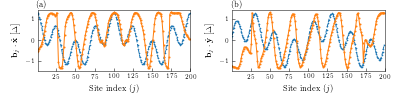

In [8]:
params = rgf_grape.independent_spins.parameters.Parameters(fold_optim+'params.ini', create_all=False)
params.set('CALLBACK', 'out_folder', 'SM_data/')
params.generate()
delta = params.wire.delta.mean()

x_values = rgf_grape.data_analysis.load_xvals_pkl(fold_optim_results+'opt_0_iter.pkl')
x_values = x_values[[0,-1]]
output_file=fold_optim+'res_init.pkl'
fig_SM(params, x_values, output_file, name_figS2, False)

<IPython.core.display.Javascript object>


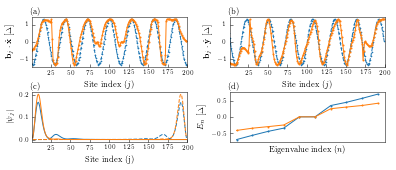

1584
Gaps from diagonalization of the open boundary condition Hamiltonian (sc region only) =
0.35898795717884946
0.25858138962745375
MZM energy splitting = 
0.000788954082613944
1.5474268813062373e-05


In [9]:
# We now fit the obtained magnetic texture to an helical magnetic field.
sites = np.array([i for i in range(1, params.wire.N+1)])

# optimized texture
field = np.array([params.wire.local_zeeman_field(s) for s in sites])/delta
field -= params.wire.uniformField/delta

# Fit to optimization result
out = cos_fit_with_lmfit(sites, field[:,0])
mu = x_values[-1][-1]
x_values[0] = [i*2*np.pi/out.params['wl'].value+ out.params['phase'].value for i in sites]*2+[mu]

# Plotting the figure
output_file=fold_optim+'res_fit.pkl'
fig_SM(params, x_values, output_file, name_figS3, True)